# Training DCGAN in PyTorch

---

In [1]:
import numpy as np
import argparse
import torch
import cv2
import os
import matplotlib.pyplot as plt

from IPython.display import Image

In [2]:
#biblitecas de ML
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
from sklearn.utils import shuffle
from imutils import build_montages
from torch.optim import Adam
from torch.nn import BCELoss
from torch.nn import ConvTranspose2d
from torch.nn import BatchNorm2d
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import LeakyReLU
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch import flatten
from torch import nn

torch.autograd.set_detect_anomaly(True)

In [25]:
args = {
    "output":"output",
    "epochs":40,
    "batch-size":512,
    "gif":r"D:\Estudos\PyImageSearch\PyTorch 103 - Advanced PyTorch Techniques\output.gif"
}

## Step 1: Define Generator --------------------------------

In [4]:
class Generator(nn.Module):
    def __init__(self, inputDim=100, outputDim=512, outputChannels=1):
        super(Generator, self).__init__()

        # CONVT => RELU => BN
        self.ct1 = ConvTranspose2d(in_channels=inputDim,
                                   out_channels=128, kernel_size=4, stride=2, padding=0,
                                   bias=False)
        self.relu1 = ReLU()
        self.batchNorm1 = BatchNorm2d(128)

        # ONVT => RELU => BN
        self.ct2 = ConvTranspose2d(in_channels=128, out_channels=64,
                                   kernel_size=3, stride=2, padding=1, bias=False)
        self.relu2 = ReLU()
        self.batchNorm2 = BatchNorm2d(64)

        # CONVT => RELU => BN
        self.ct3 = ConvTranspose2d(in_channels=64, out_channels=32,
                                   kernel_size=4, stride=2, padding=1, bias=False)
        self.relu3 = ReLU()
        self.batchNorm3 = BatchNorm2d(32)

        # TANH activation
        self.ct4 = ConvTranspose2d(in_channels=32,
                                   out_channels=outputChannels, kernel_size=4, stride=2,
                                   padding=1, bias=False)
        self.tanh = Tanh()

    def forward(self, x):

        x = self.ct1(x)
        x = self.relu1(x)
        x = self.batchNorm1(x)

        x = self.ct2(x)
        x = self.relu2(x)
        x = self.batchNorm2(x)

        x = self.ct3(x)
        x = self.relu3(x)
        x = self.batchNorm3(x)

        x = self.ct4(x)
        output = self.tanh(x)

        return output

## Step 2: Define Disciminator --------------------------------

In [5]:
class Discriminator(nn.Module):
    def __init__(self, depth, alpha=0.2):
        super(Discriminator, self).__init__()

        # fCONV => RELU layers
        self.conv1 = Conv2d(in_channels=depth, out_channels=32,
                            kernel_size=4, stride=2, padding=1)
        self.leakyRelu1 = LeakyReLU(alpha, inplace=True)

        # CONV => RELU layers
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=4,
                            stride=2, padding=1)
        self.leakyRelu2 = LeakyReLU(alpha, inplace=True)

        # FC => RELU layers
        self.fc1 = Linear(in_features=3136, out_features=512)
        self.leakyRelu3 = LeakyReLU(alpha, inplace=True)

        # sigmoid layer
        self.fc2 = Linear(in_features=512, out_features=1)
        self.sigmoid = Sigmoid()

    def forward(self, x):

        x = self.conv1(x)
        x = self.leakyRelu1(x)

        x = self.conv2(x)
        x = self.leakyRelu2(x)

        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.leakyRelu3(x)

        x = self.fc2(x)
        output = self.sigmoid(x)

        return output

## Step 3 - Custom Weight Initialization --------------------------------

In [6]:
def weights_init(model):
    classname = model.__class__.__name__

    if classname.find("Conv") != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

## Step 4 - Building data papeline --------------------------------

In [7]:
NUM_EPOCHS = args["epochs"]
BATCH_SIZE = args["batch-size"]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainData = MNIST(root  = "data", train=True, download=True,
                  transform=dataTransform)

testData = MNIST(root  = "data", train=False, download=True,
                  transform=dataTransform)

data = torch.utils.data.ConcatDataset((trainData, testData))

dataloader = DataLoader(data, shuffle = True,
                        batch_size=BATCH_SIZE)

stepsPerEpoch = len(dataloader.dataset) // BATCH_SIZE

## Step 5 - Training the Model --------------------------------

### 5.1 Compile Models --------------------------------

In [8]:
disc = Discriminator(depth=1)
disc.apply(weights_init)
disc.to(DEVICE)

Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leakyRelu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leakyRelu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (leakyRelu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [9]:
gen = Generator(inputDim = 100, outputDim =512,
                outputChannels = 1)
gen.apply(weights_init)
gen.to(DEVICE)

Generator(
  (ct1): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (relu1): ReLU()
  (batchNorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ct2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (relu2): ReLU()
  (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ct3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (relu3): ReLU()
  (batchNorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ct4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)

### 5.2 Optimizers  --------------------------------

In [10]:
genOpt = Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999),
              weight_decay=0.0002 / NUM_EPOCHS)
discOpt = Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999),
               weight_decay=0.0002 / NUM_EPOCHS)

criterion = BCELoss()

### 5.3 Benchmark Noise  --------------------------------

In [11]:
benchmarkNoise = torch.randn(256, 100, 1, 1, device=DEVICE)

### 5.4 Executing Training  --------------------------------

In [12]:
realLabel = 1
fakeLabel = 0

# create empty list to store losses
lossesG = []
lossesD = []

# loop over the epochs
for epoch in range(NUM_EPOCHS):
    # show epoch information and compute the number of batches per
    # epoch
    print("[INFO] starting epoch {} of {}...".format(epoch + 1,
                                                     NUM_EPOCHS))

    # initialize current epoch loss for generator and discriminator
    epochLossG = 0
    epochLossD = 0

    for x in dataloader:
        # zero out the discriminator gradients
        disc.zero_grad()

        # grab the images and send them to the device
        images = x[0]
        images = images.to(DEVICE)

        # get the batch size and create a labels tensor
        bs =  images.size(0)
        labels = torch.full((bs,), realLabel, dtype=torch.float,
                            device=DEVICE)

        # forward pass through discriminator
        output = disc(images).view(-1)

        # calculate the loss on all-real batch
        errorReal = criterion(output, labels)

        # calculate gradients by performing a backward pass
        errorReal.backward()

        # randomly generate noise for the generator to predict on
        noise = torch.randn(bs, 100, 1, 1, device=DEVICE)

        # generate a fake image batch using the generator
        fake = gen(noise)
        labels.fill_(fakeLabel)

        # perform a forward pass through discriminator using fake
        # batch data
        output = disc(fake.detach()).view(-1)
        errorFake = criterion(output, labels)

        # calculate gradients by performing a backward pass
        errorFake.backward()

        # compute the error for discriminator and update it
        errorD = errorReal + errorFake
        discOpt.step()

        # set all generator gradients to zero
        gen.zero_grad()

        # update the labels as fake labels are real for the generator
        # and perform a forward pass  of fake data batch through the
        # discriminator
        labels.fill_(realLabel)
        output = disc(fake).view(-1)

        # calculate generator's loss based on output from
        # discriminator and calculate gradients for generator
        errorG = criterion(output, labels)
        errorG.backward()

        # update the generator
        genOpt.step()

        # add the current iteration loss of discriminator and
        # generator
        epochLossD += errorD
        epochLossG += errorG

        # calculate average losses for the current epoch
        avgLossG = epochLossG / stepsPerEpoch
        avgLossD = epochLossD / stepsPerEpoch

        # append these values into our lists
        lossesG.append(avgLossG)
        lossesD.append(avgLossD)

    # display training information to disk
    print("[INFO] Generator Loss: {:.4f}, Discriminator Loss: {:.4f}".format(
        epochLossG / stepsPerEpoch, epochLossD / stepsPerEpoch))

    # check to see if we should visualize the output of the
    # generator model on our benchmark data
    if (epoch + 1) % 2 == 0:
        # set the generator in evaluation phase, make predictions on
        # the benchmark noise, scale it back to the range [0, 255],
        # and generate the montage
        gen.eval()
        images = gen(benchmarkNoise)
        images = images.detach().cpu().numpy().transpose((0, 2, 3, 1))
        images = ((images * 127.5) + 127.5).astype("uint8")
        images = np.repeat(images, 3, axis=-1)
        vis = build_montages(images, (28, 28), (16, 16))[0]

        # build the output path and write the visualization to disk
        p = os.path.join(args["output"], "epoch_{}.png".format(
            str(epoch + 1).zfill(4)))
        cv2.imwrite(p, vis)

        # set the generator to training mode
        gen.train()

[INFO] starting epoch 1 of 40...
[INFO] Generator Loss: 3.2733, Discriminator Loss: 0.3785
[INFO] starting epoch 2 of 40...
[INFO] Generator Loss: 3.4794, Discriminator Loss: 0.4745
[INFO] starting epoch 3 of 40...
[INFO] Generator Loss: 2.2126, Discriminator Loss: 0.7806
[INFO] starting epoch 4 of 40...
[INFO] Generator Loss: 1.3158, Discriminator Loss: 1.0254
[INFO] starting epoch 5 of 40...
[INFO] Generator Loss: 1.1257, Discriminator Loss: 1.1954
[INFO] starting epoch 6 of 40...
[INFO] Generator Loss: 1.0218, Discriminator Loss: 1.2155
[INFO] starting epoch 7 of 40...
[INFO] Generator Loss: 0.9604, Discriminator Loss: 1.2840
[INFO] starting epoch 8 of 40...
[INFO] Generator Loss: 0.9085, Discriminator Loss: 1.3125
[INFO] starting epoch 9 of 40...
[INFO] Generator Loss: 0.8416, Discriminator Loss: 1.2989
[INFO] starting epoch 10 of 40...
[INFO] Generator Loss: 0.8436, Discriminator Loss: 1.2927
[INFO] starting epoch 11 of 40...
[INFO] Generator Loss: 0.8576, Discriminator Loss: 1.29

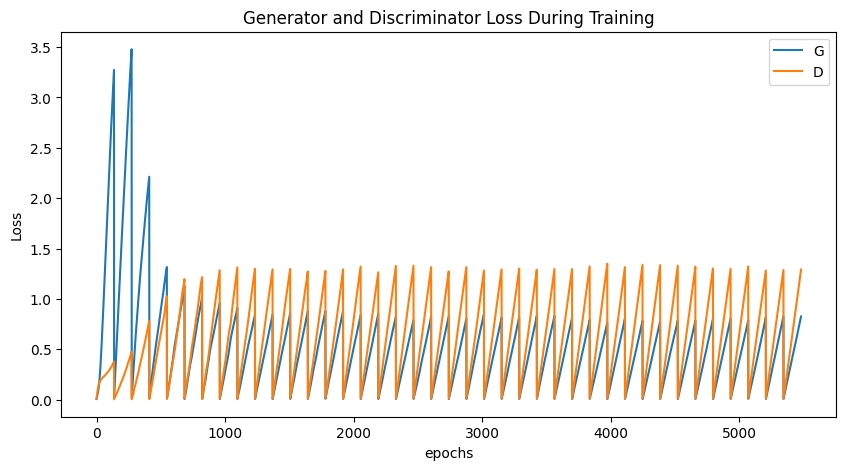

In [23]:
lossesG2 = [loss.detach().numpy() for loss in lossesG]
lossesD2 = [loss.detach().numpy() for loss in lossesD]

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(lossesG2, label="G")
plt.plot(lossesD2, label="D")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [26]:
print("[INFO] Final Generator Loss: {:.4f}, Final Discriminator Loss: {:.4f}".format(lossesG[-1], lossesD[-1]))

[INFO] Final Generator Loss: 0.8245, Final Discriminator Loss: 1.2908


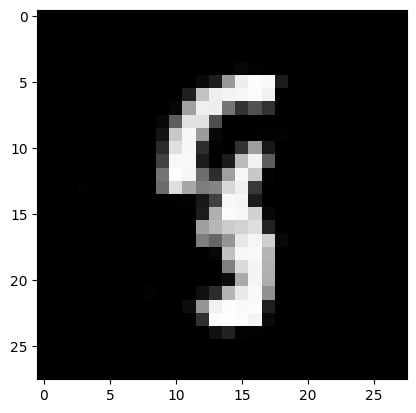

In [37]:
plt.imshow(images[100][:,:,::-1])